<a href="https://colab.research.google.com/github/NicoPP1/PDI/blob/main/TP8/TP8Parma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico Nº8 Procesamiento Digital de Imágenes - Reconstrucción y cuantización.
### Autor: Nicolás Daniel Parma Paternostro
### Consigna: 

Implementar un aplicativo que permita abrir una imagen y con esta obtener:

• Downsampling X2 (mostrando la imagen resultado al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.

• Upsampling X2 (mostrando la imagen original al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.

• Cuantización a cantidad de niveles de gris variable, utilizando uniforme, dithering aleatorio, y difusión del error por scan-line.

Todas las funciones de Downsamplig, Upsampling y Cuantización deben ser desarrolladas como funciones propias y NO con funciones de biblioteca. Les sugiero recorrer la imagen mediante ciclos for anidados para una fácil implementación.

## Fecha de entrega: 10 de Dicembre.

##Subir la imagen IC2 adjunta en el formulario de Google

###Librerias

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

###Funciones para trabajar en los espacios RGB e YIQ

In [2]:
#Función para clipear la luminancia
def clipY(mat):
    mat = np.clip(mat,0.0,1.0)
    return mat

#Función para clipear la componente en fase
def clipI(mat):
    mat = np.clip(mat,-0.5957,0.5957)          
    return mat

#Función para clipear la el componente en cuadratura
def clipQ(mat):
    mat = np.clip(mat,-0.5226,0.5226)          
    return mat

#Función para obtener componentes RGB de una imagen y devolverlo en el espacio YIQ
def RGB2YIQ(img):
    img = img.astype(float) #Cambio tipo de dato para trabajar en float
    r,g,b = RGB(img)
    r = r/255 #normalizo canales
    g = g/255 #normalizo canales
    b = b/255 #normalizo canales

    Y = (r*0.299+g*0.587+b*0.114)
    I = (r*0.595716-g*0.274453-b*0.321263)
    Q = (r*0.211456-g*0.522591+b*0.311135)

    return(Y,I,Q)

#Función para obtener los canales RGB de una imagen
def RGB(img):
    img = img.astype(float) #Cambio tipo de dato para trabajar en float
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    return r,g,b

#Función para obtener una imagen RGB a partir de los componentes YIQ modificadas
def YIQ2RGB(Y,I,Q):
    Y = clipY(Y) #función para clipear luminancia
    I = clipI(I) #función para clipear luminancia
    Q = clipQ(Q) #función para clipear luminancia

    dimension = Y.shape

    r = np.zeros((dimension[0],dimension[1]), dtype = float)
    g = np.zeros((dimension[0],dimension[1]), dtype = float)
    b = np.zeros((dimension[0],dimension[1]), dtype = float)

    r = (Y+0.9563*I+0.621*Q)*255
    g = (Y-0.2721*I-0.6474*Q)*255
    b = (Y-1.1070*I+1.7046*Q)*255

    r = np.clip(r,0,255)
    g = np.clip(g,0,255)
    b = np.clip(b,0,255)

    img = np.zeros((dimension[0],dimension[1],3),dtype = 'uint8') #Transformo a tipo de dato uint8 ya que es el requerido para mostrar las imágenes
    img[:,:,0] = r
    img[:,:,1] = g
    img[:,:,2] = b

    return(img)

## Upsampling

In [9]:
#Upsampling constante
def upConstante(Y):
    Yupcte = np.zeros((2*heightY,2*widthY))
    for i in range(heightY):
        for j in range(widthY):
                Yupcte[2*i:2*i+2,2*j:2*j+2] = Y[i,j]
            
    return Yupcte

#Upsampling bilineal
def upBilineal(Y):
    Yupbili = np.zeros((2*heightY,2*widthY))
    for i in range(heightY-1):
        for j in range(widthY-1):
                Yupbili[2*i,2*j] = Y[i,j]            
                Yupbili[2*i+1,2*j] = (Y[i,j]+Y[i+1,j])/2
                Yupbili[2*i,2*j+1] = (Y[i,j]+Y[i,j+1])/2
                Yupbili[2*i+1,2*j+1] = (Y[i,j]+Y[i,j+1]+Y[i+1,j]+Y[i+1,j+1])/4

    Yupbili = np.clip(Yupbili,0,1)
    return Yupbili 

#Upsampling bicubico
def upBicubico(Y):
    Yupbicu = np.zeros((2*heightY-2,2*widthY-2))
    for i in range(heightY-2):
        for j in range(widthY-2):
            if ((i == 0) and (j == 0)):
                a = "ignoro el origen ya que no tengo datos para realizar la operación bicubica."
            else:
                Yupbicu[2*i,2*j] = Y[i,j]            
                Yupbicu[2*i+1,2*j] = (-Y[i-1,j]+5*Y[i,j]+5*Y[i+1,j]-Y[i+2,j])/8
                Yupbicu[2*i,2*j+1] = (-Y[i,j-1]+5*Y[i,j]+5*Y[i,j+1]-Y[i,j+2])/8
                Yupbicu[2*i+1,2*j+1] = (-Y[i-1,j-1]+5*Y[i,j]+5*Y[i+1,j+1]-Y[i+2,j+2])/8

            
    Yupbicu = np.clip(Yupbicu,0,1)

    return Yupbicu

## Downsampling

In [5]:
#Downsampling constante
def downConstante(Y):
    Ydowncte = np.zeros((heightY//2,widthY//2))
    for i in range(heightY//2):
        for j in range(widthY//2):
                Ydowncte[i,j] = Y[2*i,2*j]
    return Ydowncte

#Downsampling bilineal
def downBilineal(Y):
    Ydownbili = np.zeros((heightY//2,widthY//2))
    for i in range(heightY//2):
        for j in range(widthY//2):
                Ydownbili[i,j] = (Y[2*i,2*j]+Y[2*i+1,2*j]+Y[2*i,2*j+1]+Y[2*i+1,2*j+1])/4        

    Ydownbili = np.clip(Ydownbili,0,1)

    return Ydownbili

#Downsampling bicubico
def downBicubico(Y):
    Ydownbicu = np.zeros((heightY//2-2,widthY//2-2))
    for i in range(heightY//2-2):
        for j in range(widthY//2-2):
            if ((i == 0) and (j == 0)):
                a = "ignoro el origen ya que no tengo datos para realizar la operación bicubica."
            else:
                Ydownbicu[i,j] = (((-Y[2*i-1,2*j]+5*Y[2*i,2*j]+5*Y[2*i+1,2*j]-Y[2*i+2,2*j])/8)+(-Y[2*i,2*j-1]+5*Y[2*i,2*j]+5*Y[2*i,2*j+1]-Y[2*i,2*j+2])/8)/2       

    Ydownbicu = np.clip(Ydownbicu,0,1)
    return Ydownbicu

## Cuantización

In [6]:
#Función para asignar valor mas cercano a uno de los valores de cuantización
def find_nearest(k, value):

    array = np.linspace(0,1,k)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

#Cuantización uniforme
def cuantizacionUniforme(Y,k):
    Ycuant = np.zeros((heightY,widthY))
    for i in range(heightY):
        for j in range(widthY):
            Ycuant[i,j] = find_nearest(k,Y[i,j])
    return Ycuant

#Dithering Aleatorio
def ditheringAleatorio(Y,k):
    Ydit = np.zeros((heightY,widthY)) 
    for i in range(heightY):
        for j in range(widthY):
            Ydit[i,j] = Y[i,j]*(k-1)+(np.random.rand()-0.5)/(k-1)

    Ydit = np.clip(Ydit,0,1)
    return Ydit

#Difusion del error
def difusionError(Y):
    Ydif = np.zeros((heightY,widthY))

    for i in range(heightY):
        error = 0.0
        for j in range(widthY):
            Ydif[i,j] = np.round(Y[i,j] - error,1)
            error = error + Ydif[i,j] - Y[i,j]
            
    Ydif = np.clip(Ydif,0,1)
    return Ydif

### Aplicativo que permite seleccionar una imagen y la operación a aplicar y mostrar el resultado obtenido. Se puede descargar la imagen obtenida al aplicar el filtro presionando el botón "descargar imagen", la misma se guarda como img.jpg. 


In [7]:
import ipywidgets as widgets
from IPython.display import display

aplicar = widgets.Button(description = "aplicar operacion")
descarga = widgets.Button(description = "descargar imagen")
#@title Ingrese la URL de la imagen deseada y luego seleccione el filtro a realizar (la variable k es utilizando para la cuantizacion uniforme y dithering aleatorio) { run: "auto", vertical-output: true }

u = "Radiografia" #@param ["IC", "IC2", "Fondo de ojo", "Radiografia"]
if u == "IC":
    url = "https://www.electan.com/images/Sparkfun/11107-01.jpg"
elif u == "Fondo de ojo":
    url = "https://www.rahhal.com/blog/wp-content/uploads/2015/07/fondo-ojo-normal.jpg"
elif u == "Radiografia":
    url = "https://faros.hsjdbcn.org/sites/default/files/styles/ficha-contenido/public/radiografia_de_torax_-_imagen_-.jpg?itok=-Nikjhh3"
elif u == "IC2":
    url = "/content/IC2.png"

img = imageio.imread(url)

op = "ditheringAleatorio" #@param ["upConstante", "upBilineal", "upBicubico", "downConstante", "downBilineal", "downBicubico", "cuantizacionUniforme", "ditheringAleatorio", "difusionError"]
k =  2#@param {type:"integer"}

Y,I,Q = RGB2YIQ(img)

shapeY = Y.shape
heightY = shapeY[0]
widthY = shapeY[1]


def on_aplicar_clicked(b):
    print(f"Aplicar {op} a {u}")

    if op == 'upConstante':
        Yop = upConstante(Y)
    elif op == 'upBilineal':
        Yop = upBilineal(Y)
    elif op == 'upBicubico':
        Yop = upBicubico(Y)
    if op == 'downConstante':
        Yop = downConstante(Y)
    elif op == 'downBilineal':
        Yop = downBilineal(Y)
    elif op == 'downBicubico':
        Yop = downBicubico(Y)
    if op == 'cuantizacionUniforme':
        Yop = cuantizacionUniforme(Y,k)
    elif op == 'ditheringAleatorio':
        Yop = ditheringAleatorio(Y,k)
    elif op == 'difusionError':
        Yop = difusionError(Y)

    dpi = plt.rcParams['figure.dpi']
    figsize1 = widthY / float(dpi), heightY / float(dpi)
    figsize2 = 2*widthY / float(dpi), 2*heightY / float(dpi)

    if ((op == "upConstante") or (op == "upBilineal") or (op == "upBicubico")):
        plt.figure(figsize = figsize2)
        plt.title("original")
        plt.imshow(Y,'gray')

        plt.figure(figsize = figsize2)
        plt.title(op)
        plt.imshow(Yop,'gray')
    elif ((op == "downConstante") or (op == "downBilineal") or (op == "downBicubico")):
        plt.figure(figsize = figsize1)
        plt.title("original")
        plt.imshow(Y,'gray')

        plt.figure(figsize = figsize1)
        plt.title(op)
        plt.imshow(Yop,'gray')
    else:
        plt.figure()
        plt.title("original")
        plt.imshow(Y,'gray')

        plt.figure()
        plt.title(op)
        plt.imshow(Yop,'gray')
    print("Aplicado")

def on_descarga_clicked(b):
    plt.imsave('/content/img.jpg',YopMorph,cmap = 'gray')
    plt.imshow(YopMorph,cmap = 'gray')
    print("Descarga realizada correctamente")

    
aplicar.on_click(on_aplicar_clicked)
descarga.on_click(on_descarga_clicked)

display(aplicar,descarga)

Button(description='aplicar operacion', style=ButtonStyle())

Button(description='descargar imagen', style=ButtonStyle())

### Aplico todas las operaciones a la imagen anterior para poder visualizar los efectos de cada una en particular

In [10]:
Yupcte = upConstante(Y)
Yupbili = upBilineal(Y)
Yupbicu = upBicubico(Y)

Ydowncte = downConstante(Y)
Ydownbili = downBilineal(Y)
Ydownbicu = downBicubico(Y)

Ycuant = cuantizacionUniforme(Y,k)
Ydit = ditheringAleatorio(Y,k)
Ydif = difusionError(Y)

### Visualización de las distintas operaciones

Text(0.5, 1.0, 'Difusion de error para un decimal')

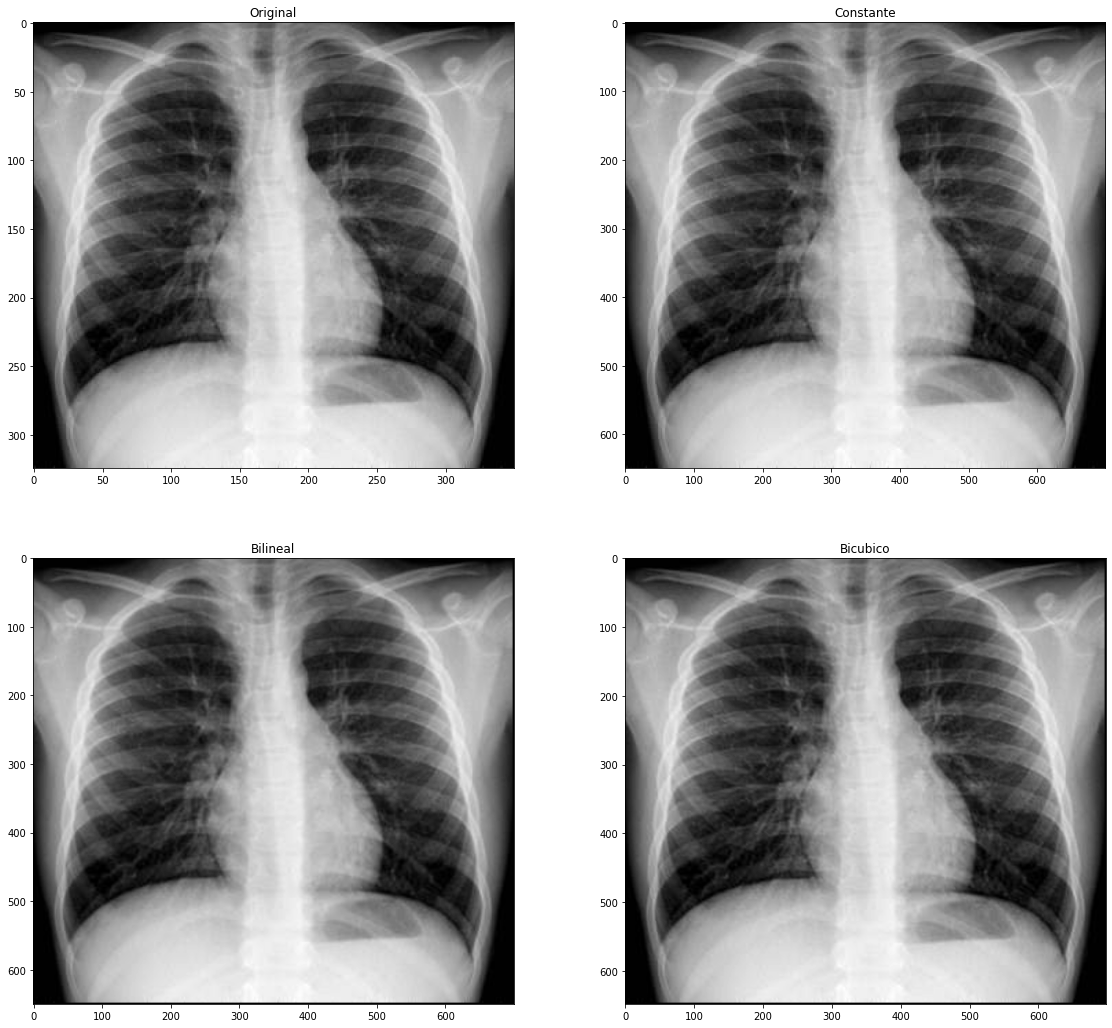

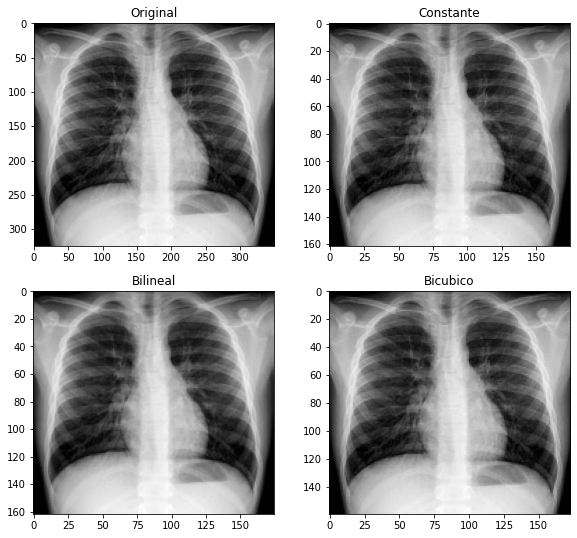

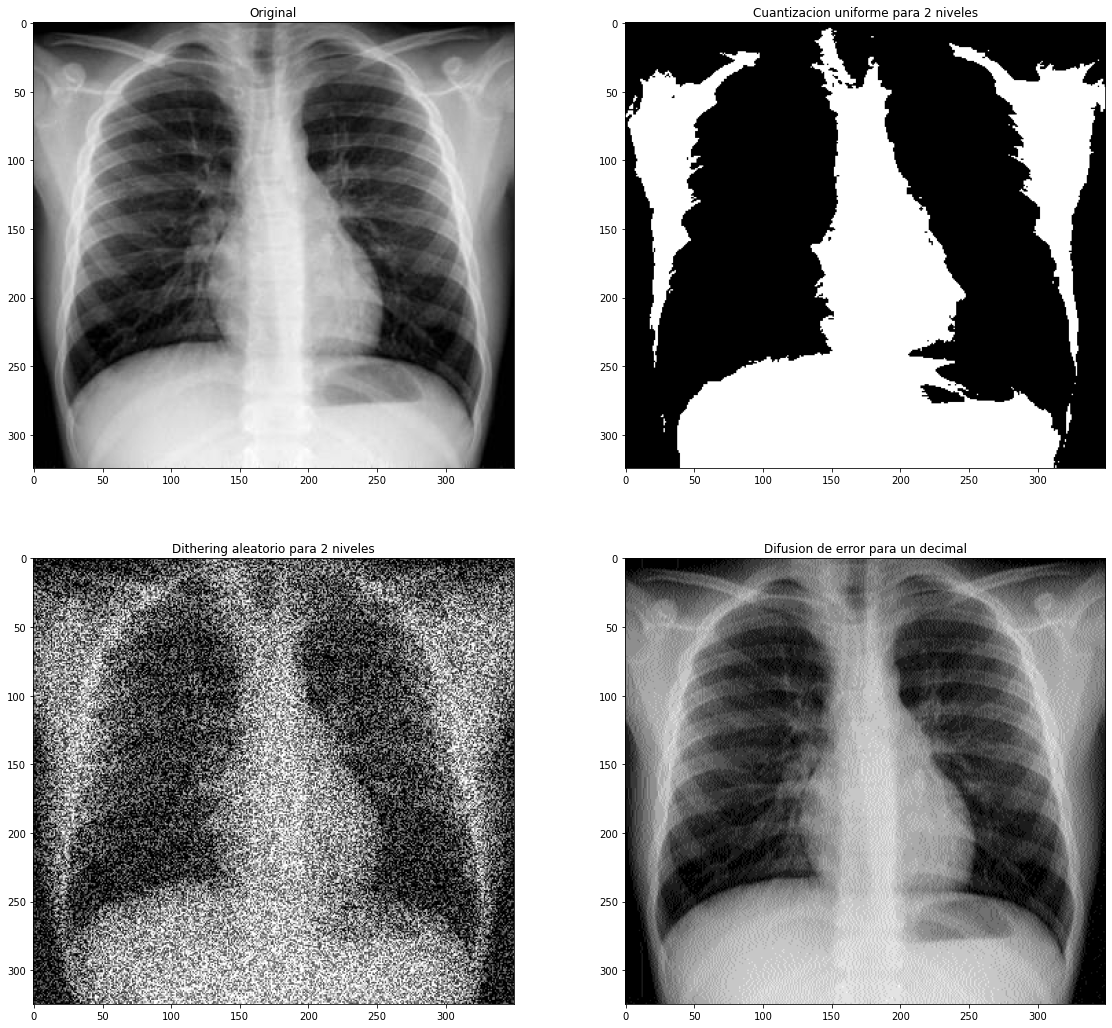

In [11]:
dpi = plt.rcParams['figure.dpi']
figsize1 = 2*widthY / float(dpi), 2*heightY / float(dpi)
figsize2 = 4*widthY / float(dpi), 4*heightY / float(dpi)

fig, ax = plt.subplots(2,2, figsize = figsize2)
ax[0,0].imshow(Y,'gray')
ax[0,0].set_title("Original")
ax[0,1].imshow(Yupcte, 'gray')
ax[0,1].set_title("Constante")
ax[1,0].imshow(Yupbili,'gray')
ax[1,0].set_title("Bilineal")
ax[1,1].imshow(Yupbicu,'gray')
ax[1,1].set_title("Bicubico")

fig2, ax2 = plt.subplots(2,2, figsize = figsize1)
ax2[0,0].imshow(Y,'gray')
ax2[0,0].set_title("Original")
ax2[0,1].imshow(Ydowncte, 'gray')
ax2[0,1].set_title("Constante")
ax2[1,0].imshow(Ydownbili,'gray')
ax2[1,0].set_title("Bilineal")
ax2[1,1].imshow(Ydownbicu,'gray')
ax2[1,1].set_title("Bicubico")

fig3, ax3 = plt.subplots(2,2, figsize = figsize2)
ax3[0,0].imshow(Y,'gray')
ax3[0,0].set_title("Original")
ax3[0,1].imshow(Ycuant,'gray')
ax3[0,1].set_title(f"Cuantizacion uniforme para {k} niveles")
ax3[1,0].imshow(Ydit,'gray')
ax3[1,0].set_title(f"Dithering aleatorio para {k} niveles")
ax3[1,1].imshow(Ydif,'gray')
ax3[1,1].set_title("Difusion de error para un decimal")

# Análisis de resultados


Al aplicar el upsampling tanto para los casos de kernel constante, bilineal y bicúbico, se observa que se amplia el tamaño en un factor de dos (como era esperado) sin pérdida de información ni de entedimiento de la imagen. Se destaca la facilidad de implementación y buenos resultados a un bajo costo computacional de los kernel constante y bilineal. Por otro lado, para el caso del kernel bicúbico es necesario una mayor cantidad de recursos, sin obtener un resultado superador a primera vista.

Para el downsampling, se observa la reducción de la resolución de la imagen (por lo tanto existe pérdida de información), sin embargo, la imagen sigue siendo inteligible, por lo que se considera como una operación adecuada de compresión. Nuevamente se destaca la facilidad de implementación de los kernel constante y bilineal. Sin embargo, para el caso del downsampling bilineal, el mismo se implementó con mayor facilidad que su contraparte en upsampling.

Luego, en cuanto a los métodos de cuantización, se observa para la cuantización uniforme la necesidad de implementar una función complementaria que dado un arreglo de N valores, al ingresar un valor de luminancia, se obtenga el valor mas cercano dentro del arreglo para poder cuantizar la imagen. El resultado es el esperado para 2 niveles ya que se obtiene una imagen completamente binaria, es decir, en blanco y negro. Sin embargo, la misma es ininteligible ya que no se puede determinar a que corresponde la misma. En cuanto al dithering aleatorio, se observa que la imagen resultado es muy parecida a la original, afectada por un ruido de alta frecuencia que podría ser fácilmente filtrado utilizando los metodos vistos en los prácticos anteriores. Para este caso, se tiene una noción de que se trata la imagen, ya que se puede determinar que la misma corresponde a una radiografía de torax. Por último, el método de difusión de error provee un menor ruido de cuantización con respecto al dithering aleatorio. La cantidad de niveles utilizados para esta imagen es 11, ya que se redondea la luminancia con 1 decimal (0, 0.1, 0.2, ... , 1).


